## CO2 Sequestration in NYC Street Trees Between 1995 and 2015

### Research Question
#### Among NYC street trees, which species include the largest trees and how much CO2 did these species store in a 20 year period?

### Methods
##### First, I generated descriptive statistics and a boxplot of tree diameter-at-breastheight (dbh) for 1995 and 2015. 
- Libraries used: pandas, numpy, seaborn
##### Next, I identified which species included most of the large trees in the city in 1995 and 2015.
- Libraries used: pandas, matplotlib
##### To determine the CO2 stored by these species in 1995 and 2015, I followed the process described by the US Forest Service. I wrote a function called get_carbon_storage that matches each species with the correct allometric equation for determining dry weight biomass. The function adds two new columns to each dataframe displaying dw biomass and kg of CO2 stored by the tree.
- Libraries used: pandas
##### Finally, I created a new dataframe showing total CO2 stored by each species in 1995 and 2015. I added a new column displaying the difference in amount of CO2 between the two years. I visualized the results with a pie chart and a bar chart. 
- Libraries used: pandas, matplotlib

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
os.chdir('C:/Users/roseh/Desktop/785/tree_census/Data')

In [4]:
# read in all dataframes

tree_1995 = pd.read_csv('1995_Street_Tree_Census.csv',usecols=['Diameter','Borough','Spc_Common','Spc_Latin'])
tree_2015 = pd.read_csv('2015_Street_Tree_Census.csv',usecols=['tree_dbh','spc_latin','spc_common','borough'])

In [5]:
# equations require dbh in centimeters
# add new column to dataframes converting dbh measurement from inches to centimeters

tree_1995['dbh_cm'] = tree_1995['Diameter']*2.54
tree_2015['dbh_cm'] = tree_2015['tree_dbh']*2.54

### How should we define 'large' for NYC street trees?

In [6]:
# Display descriptive statistics for dbh in 1995 and 2015

dbh_df = pd.DataFrame({'1995':tree_1995['dbh_cm'],'2015':tree_2015['dbh_cm']})      # read dbh data into a dataframe

print('\tTotal Number of Trees')
print('1995:', len(tree_1995))
print('2015:', len(tree_2015))

print('\n\tMean DBH')
print('1995:',np.around(dbh_df['1995'].mean(),2))
print('2015:', np.around(dbh_df['2015'].mean(),2))

print('\n\tMedian DBH')
print('1995:',np.around(dbh_df['1995'].median(),2))
print('2015:', np.around(dbh_df['2015'].median(),2))

print('\n\tMax DBH')
print('1995:',np.around(dbh_df['1995'].max(),2))
print('2015:', np.around(dbh_df['2015'].max(),2))

	Total Number of Trees
1995: 516989
2015: 683788

	Mean DBH
1995: 29.06
2015: 28.65

	Median DBH
1995: 25.4
2015: 22.86

	Max DBH
1995: 241.3
2015: 1143.0


- Between 1995 and 2015, the mean and median diameters of trees remained stable. 
- However, in 2105 the total number of trees and maximum dbh increased and more trees were above average dbh.
- Based on the mean dbh values, we will define 'large' as a dbh > 30 cm

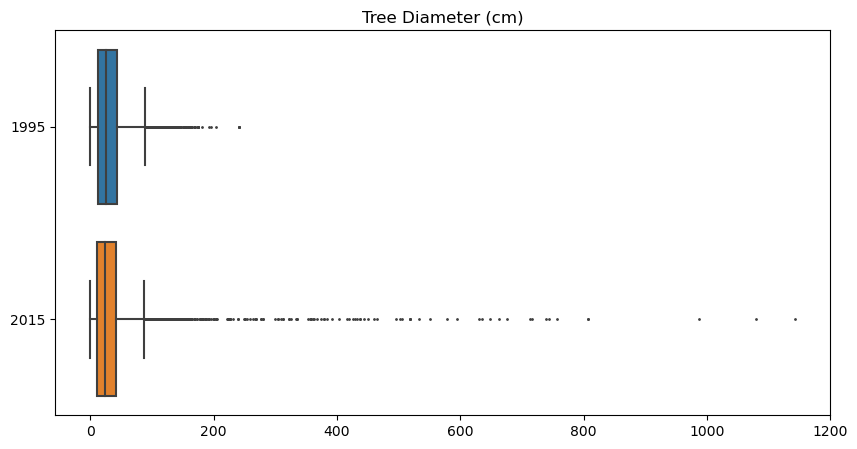

In [7]:
# create boxplot to visualize changes in dbh

fig,ax = plt.subplots(figsize=(10,5))                                              

sns.boxplot(data=dbh_df[['1995','2015']],
            ax=ax,
            orient='h', 
            flierprops={"marker": "o"}, 
            fliersize=1)
ax.set_title('Tree Diameter (cm)')

plt.show()

### Which species include the most trees with dbh > 30?

In [14]:
# select only large trees (dbh > 30) and create new dataframes

largest_1995 = tree_1995[tree_1995['dbh_cm']>30]
largest_2015 = tree_2015[tree_2015['dbh_cm']>30]

In [15]:
top_species_1995 = largest_1995['Spc_Common'].value_counts().head(10)     # find the 10 species with the most large trees in 1995 
top_species_1995

LONDON PLANETREE       69886
MAPLE, NORWAY          57614
OAK, PIN               20144
MAPLE, SILVER          15414
MAPLE, SUGAR            7600
MAPLE, RED              6186
LINDEN, LITTLE LEAF     5545
MAPLE, SYCAMORE         3771
OAK, NORTHERN RED       3346
HONEYLOCUST             3136
Name: Spc_Common, dtype: int64

In [16]:
top_species_2015 = largest_2015['spc_common'].value_counts().head(10)     # find the 10 species with the most large trees in 2015
top_species_2015

London planetree     75702
pin oak              34815
honeylocust          24978
Norway maple         22314
Callery pear         13084
littleleaf linden    10239
green ash            10225
silver maple          9924
Japanese zelkova      6365
red maple             6318
Name: spc_common, dtype: int64

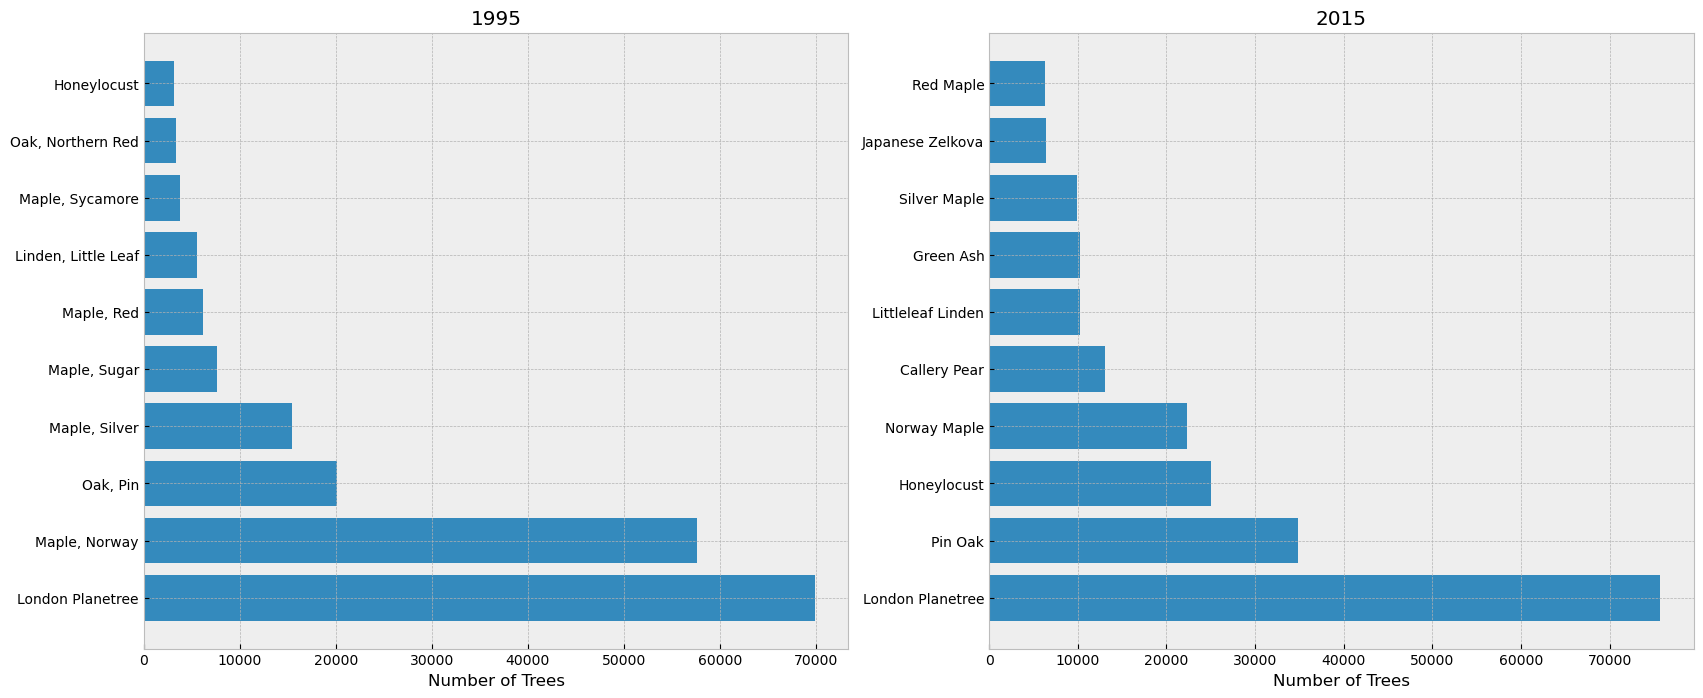

In [159]:
# create two bar charts to show which species had most large trees in each year

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
plt.style.use('bmh')
ax1.barh(top_species_1995.index.str.title(),top_species_1995)
ax1.set_title('1995')
ax1.set_xlabel('Number of Trees')

ax2.barh(top_species_2015.index.str.title(),top_species_2015)
ax2.set_title('2015')
ax2.set_xlabel('Number of Trees')
plt.show()

- In both years, most of the trees with over 30cm dbh were London Planetrees. 
- Sycamore Maple, Northern Red Oak, and Sugar Maple appear only in 1995.
- They are replaced by Japanese Zelkova, Green Ash and Callery Pear in 2015.

### How Much CO2 Was stored by these Species Between 1995 and 2015?

According to the Urban Tree Database and Allometric Equations, the process for calculating the amount of CO2 sequestered in a tree is as follows:
- Find the aboveground dry weight biomass of the tree by using the species appropriate allometric equation.
- Multiply the this biomass by 1.28 to incorporate belowground biomass.
- Multiply by the constant 0.5 to convert to total carbon stored in kg.
- Multiply by the constant 3.67 (the molecular weight of CO2) to convert to the total CO2 stored in kg.

In [50]:
# define a function to iterate over a list of dataframes and perform the above calculations

def get_carbon_storage(df_list,function_list):
    """Take a list of tree species dataframes and a list of species allometric equations. Match
    each species to the corresponding equation (based on position in list). Add a column for dry 
    weight biomass and a column for amount of CO2 to the dataframe"""
    
    zipped = zip(df_list,function_list)
    for df,function in list(zipped):
        df['dw_biomass'] = df['dbh_cm'].apply(function)
        df['CO2'] = df['dw_biomass']*1.28*.5*3.67
    

In [51]:
# select only trees with dbh greater than 0 (to avoid zero division error in some allometric equations)

greater_than_0_1995 = tree_1995[tree_1995['dbh_cm']>0]
greater_than_0_2015 = tree_2015[tree_2015['dbh_cm']>0]

In [52]:
# group the dataframes by species

species_groups_1995 = greater_than_0_1995.groupby('Spc_Common')
species_groups_2015 = greater_than_0_2015.groupby('spc_common')

In [53]:
# define empty lists that will be input into get_carbon_storage function

function_list = []
species_list_1995 = []
species_list_2015 = []

In [54]:
# define separate dataframes for each species and define allometric functions for each species.
# append each dataframe and function to the corresponding list.

londonplane_1995 = species_groups_1995.get_group('LONDON PLANETREE')
londonplane_2015 = species_groups_2015.get_group('London planetree')

londonplane_function = lambda x: (0.000059*x**2.673578) * 500    # equation for volume, multiplied by density factor

species_list_1995.append(londonplane_1995)          
species_list_2015.append(londonplane_2015)
function_list.append(londonplane_function)

In [55]:
norwaymaple_1995 = species_groups_1995.get_group('MAPLE, NORWAY')
norwaymaple_2015 = species_groups_2015.get_group('Norway maple')

norwaymaple_function = lambda x: (0.0019421*x**1.785) * 520      # equation for volume, multiplied by density factor

species_list_1995.append(norwaymaple_1995)
species_list_2015.append(norwaymaple_2015)
function_list.append(norwaymaple_function)

In [56]:
pinoak_1995 = species_groups_1995.get_group('OAK, PIN')
pinoak_2015 = species_groups_2015.get_group('pin oak')

pinoak_function = lambda x: np.exp(-2.0127+2.4342*np.log(x))- np.exp((-4.0813+5.8816/x))   # no specific function available; using general equation for maple/oak/hickory/beech

species_list_1995.append(pinoak_1995)
species_list_2015.append(pinoak_2015)
function_list.append(pinoak_function)

In [57]:
silvermaple_1995 = species_groups_1995.get_group('MAPLE, SILVER')
silvermaple_2015 = species_groups_2015.get_group('silver maple')

silvermaple_function = lambda x: (0.000363*x**2.292) * 440       # equation for volume, multiplied by density factor

species_list_1995.append(silvermaple_1995)
species_list_2015.append(silvermaple_2015)
function_list.append(silvermaple_function)

In [58]:
redmaple_1995 = species_groups_1995.get_group('MAPLE, RED')
redmaple_2015 = species_groups_2015.get_group('red maple')

redmaple_function = lambda x: 0.1970*x**2.1933             # equation for dry weight biomass

species_list_1995.append(redmaple_1995)
species_list_2015.append(redmaple_2015)
function_list.append(redmaple_function)

In [59]:
linden_1995 = species_groups_1995.get_group('LINDEN, LITTLE LEAF')
linden_2015 = species_groups_2015.get_group('littleleaf linden')

linden_function = lambda x: (0.0009359*x**2.042) * 420     # equation for volume, multiplied by density factor

species_list_1995.append(linden_1995)
species_list_2015.append(linden_2015)
function_list.append(linden_function)

In [60]:
honeylocust_1995 = species_groups_1995.get_group('HONEYLOCUST')
honeylocust_2015 = species_groups_2015.get_group('honeylocust')

honeylocust_function = lambda x: (0.0005055*x**2.22) * 600  # equation for volume, multiplied by density factor

species_list_1995.append(honeylocust_1995)
species_list_2015.append(honeylocust_2015)
function_list.append(honeylocust_function)

In [61]:
greenash_1995 = species_groups_1995.get_group('ASH, GREEN')
greenash_2015 = species_groups_2015.get_group('green ash')

greenash_function = lambda x: (0.0005885*x**2.206) * 530  # equation for volume, multiplied by density factor

species_list_1995.append(greenash_1995)
species_list_2015.append(greenash_2015)
function_list.append(greenash_function)

In [62]:
zelkova_1995 = species_groups_1995.get_group('ZELKOVA, JAPANESE')
zelkova_2015 = species_groups_2015.get_group('Japanese zelkova')

zelkova_function = lambda x: (0.0000502*x**2.674757) * 520    # equation for volume, multiplied by density factor

species_list_1995.append(zelkova_1995)
species_list_2015.append(zelkova_2015)
function_list.append(zelkova_function)

In [63]:
get_carbon_storage(species_list_1995,function_list)     # apply function to 1995 species

In [64]:
get_carbon_storage(species_list_2015,function_list)     # apply function to 2015 species

In [66]:
# define list of species names
# define list of total CO2 amounts for each species in 1995
# define list of total CO2 amounts for each species in 2015

species = ['London Plane','Norway Maple', 'Pin Oak', 'Silver Maple', 'Red Maple', 'Linden', 'Honey Locust', 'Green Ash', 'Japanese Zelkova']
co2_1995 = [londonplane_1995['CO2'].sum(), norwaymaple_1995['CO2'].sum(), pinoak_1995['CO2'].sum(), silvermaple_1995['CO2'].sum(),redmaple_1995['CO2'].sum(),
            linden_1995['CO2'].sum(),honeylocust_1995['CO2'].sum(),greenash_1995['CO2'].sum(),zelkova_1995['CO2'].sum()]
co2_2015 = [londonplane_2015['CO2'].sum(), norwaymaple_2015['CO2'].sum(), pinoak_2015['CO2'].sum(), silvermaple_2015['CO2'].sum(),redmaple_2015['CO2'].sum(),
            linden_2015['CO2'].sum(),honeylocust_2015['CO2'].sum(),greenash_2015['CO2'].sum(),zelkova_2015['CO2'].sum()]

In [72]:
# create dataframe showing species and total CO2 amounts

co2_storage = pd.DataFrame({'species':species,'1995':co2_1995,'2015':co2_2015})

In [74]:
# add a column showing the amount of CO2 added or lost by each species between 1995 and 2015

co2_storage['CO2_difference'] = co2_storage['2015'] - co2_storage['1995']
co2_storage.set_index('species',inplace=True)

### Visualize the Results
- The three species that showed the greatest increase in CO2 storage over the 20 year period were Pin Oak, London Plane, and Honeylocust. 
- The species that stored less CO2 after 20 years were Norway Maple, Silver Maple and Red Maple. (Perhaps we can surmise that maple trees are on a decline in the city.)
- In both years, Londonplane trees stored the most CO2. This species stored 2.68x10^8 kg of CO2 in 1995 and 3.84x10^8 kg in 2015. 

In [75]:
# display dataframe
co2_storage

,1995,2015,CO2_difference
species,,,
London Plane,2.672230e+08,3.840120e+08,1.167890e+08
Norway Maple,1.519581e+08,5.554099e+07,-9.641715e+07
Pin Oak,1.097677e+08,2.604597e+08,1.506920e+08
Silver Maple,7.650997e+07,5.629436e+07,-2.021561e+07
Red Maple,1.754059e+07,1.723237e+07,-3.082151e+05
Linden,2.089216e+07,2.984548e+07,8.953316e+06
Honey Locust,1.884902e+07,8.574100e+07,6.689198e+07
Green Ash,1.418027e+07,3.609985e+07,2.191957e+07
Japanese Zelkova,1.113944e+06,1.328290e+07,1.216895e+07


In [157]:
# sort CO2_difference column to show which species gained the most CO2 over 20 years

co2_storage['CO2_difference'].sort_values(ascending=False)

species
Pin Oak             1.506920e+08
London Plane        1.167890e+08
Honey Locust        6.689198e+07
Green Ash           2.191957e+07
Japanese Zelkova    1.216895e+07
Linden              8.953316e+06
Red Maple          -3.082151e+05
Silver Maple       -2.021561e+07
Norway Maple       -9.641715e+07
Name: CO2_difference, dtype: float64

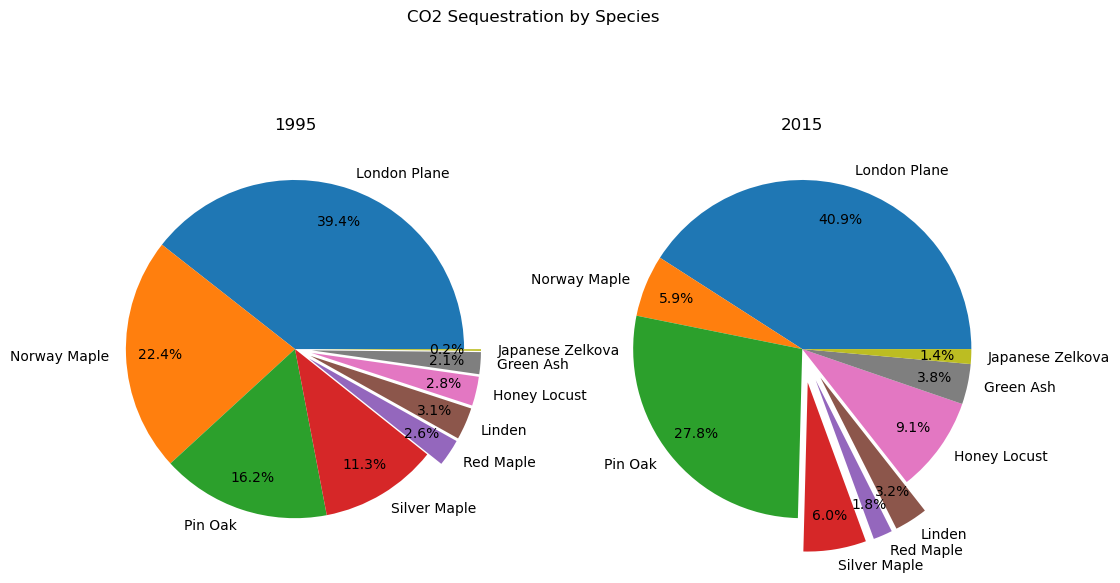

In [111]:
# create pie charts to show relative co2 storage by each species

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,7))
fig.suptitle('CO2 Sequestration by Species')

ax1.pie(co2_storage['1995'],labels=co2_storage.index,autopct='%1.1f%%',
       explode=[0,0,0,0,.1,.1,.1,.1,.1],pctdistance=.8,labeldistance=1.1)
ax1.set_title('1995')

ax2.pie(co2_storage['2015'],labels=co2_storage.index, autopct='%1.1f%%',
       pctdistance=.8,explode=[0,0,0,.2,.2,.2,0,0,0],labeldistance=1.1)
ax2.set_title('2015')
plt.show()
                    

In [112]:
# create barchart to show absolute co2 storage by species

by_year = co2_storage.T                                # transpose dataframe
by_year.drop('CO2_difference',axis=0,inplace=True)

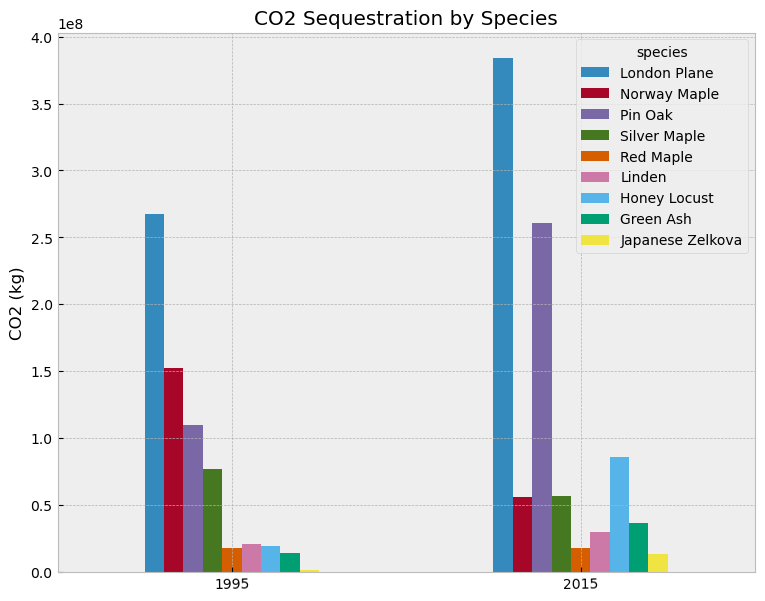

In [154]:
by_year.plot(kind='bar',figsize=(9,7),rot=1,title='CO2 Sequestration by Species',ylabel='CO2 (kg)')

plt.show()